In [160]:
# minimal module imports
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayer
from arcgis.geometry import Geometry
from ba_data_paths import ba_data
import pandas as pd
import os
import importlib
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# import arcpy if available
if importlib.util.find_spec("arcpy") is not None:
    import arcpy
    
import sys
sys.path.append('../src')

app_id = 'c9fa4c15-b9ab-46d4-bcd9-a3eb33dd0ff8'
hash_token = '919745fda981ddccb3ffc4f07863480e624cfa3d'

data_dir = Path(os.path.abspath('../data'))

interim_dir = data_dir/'interim'
interim_gdb = interim_dir/'interim.gdb'

raw_dir = data_dir/'raw'
raw_gdb = raw_dir/'raw.gdb'
                
nearest_stores_csv = interim_dir/'closest_store.csv'
nearest_comp_csv = interim_dir/'closest_competition.csv'

origin_fc = str(raw_gdb/'sea_block_group')
origin_id_fld = 'ID'

dest_fc = str(raw_gdb/'sea_ace')
dest_fc_fld = 'LOCNUM'

comp_fc = raw_gdb/'sea_ace_comp'
comp_id_fld = 'LOCNUM'

from inrix import TAZ
taz = TAZ(app_id, hash_token)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df_pop_cent = GeoAccessor.from_featureclass(dest_fc)

In [17]:
geom = df_pop_cent.iloc[0].SHAPE

In [8]:
def get_dest_df(geom, locnum):
    dest_df = taz.get_trip_destination_spatial_dataframe(geom.y, geom.x, '100m')
    if dest_df is not None:
        dest_df = dest_df[['travelDistanceMiles', 'travelTimeMinutes', 'SHAPE']].copy()
        dest_df.columns = ['travel_distance_miles', 'travel_time_minutes', 'SHAPE']
        dest_df['store_locnum'] = locnum
        dest_df['x'] = dest_df.SHAPE.apply(lambda geom: geom.x)
        dest_df['y'] = dest_df.SHAPE.apply(lambda geom: geom.y)
        return dest_df
    else:
        return None

In [25]:
dest_df=None
for idx, (locnum, geom) in df_pop_cent[['LOCNUM', 'SHAPE']].iterrows():
    new_df = get_dest_df(geom, locnum)
    if new_df is not None:
        if idx == 0:
            dest_df = new_df
            print(f'{len(dest_df.index):,}')
        else:
            dest_df = dest_df.append(new_df)
            print(f'{len(dest_df.index):,}')
            
dest_df.head()

388
1,180
5,542
5,646
5,960
5,967
6,849
7,239
7,739
9,722
11,705
11,831
12,835
14,272
15,808
17,653
19,498
23,229
27,790
36,894
45,998
47,585
49,383
50,661
51,714
52,358
53,002
54,183
54,615
54,764
54,913
55,081
55,403
56,072
56,741
57,289


,travel_distance_miles,travel_time_minutes,SHAPE,store_locnum,x,y
0,2.426454,9.316667,"{""x"": -122.300817, ""y"": 47.023922, ""spatialRef...",371889957,-122.300817,47.023922
1,5.910481,17.183333,"{""x"": -122.277817, ""y"": 47.089246, ""spatialRef...",371889957,-122.277817,47.089246
2,1.614322,12.366667,"{""x"": -122.28159, ""y"": 47.07345, ""spatialRefer...",371889957,-122.281590,47.073450
3,2.308393,11.383333,"{""x"": -122.300815, ""y"": 47.023904, ""spatialRef...",371889957,-122.300815,47.023904
4,3.017999,10.333333,"{""x"": -122.317497, ""y"": 47.072956, ""spatialRef...",371889957,-122.317497,47.072956


In [26]:
dest_df.spatial.set_geometry('SHAPE')
dest_df.spatial.validate()

True

In [27]:
dest_df.reset_index(drop=True, inplace=True)
dest_df.head()

,travel_distance_miles,travel_time_minutes,SHAPE,store_locnum,x,y
0,2.426454,9.316667,"{""x"": -122.300817, ""y"": 47.023922, ""spatialRef...",371889957,-122.300817,47.023922
1,5.910481,17.183333,"{""x"": -122.277817, ""y"": 47.089246, ""spatialRef...",371889957,-122.277817,47.089246
2,1.614322,12.366667,"{""x"": -122.28159, ""y"": 47.07345, ""spatialRefer...",371889957,-122.281590,47.073450
3,2.308393,11.383333,"{""x"": -122.300815, ""y"": 47.023904, ""spatialRef...",371889957,-122.300815,47.023904
4,3.017999,10.333333,"{""x"": -122.317497, ""y"": 47.072956, ""spatialRef...",371889957,-122.317497,47.072956


In [28]:
dest_df.to_csv('../data/interim/raw_trips_sea_ace.csv')

In [30]:
dest_df.spatial.to_featureclass('../data/interim/interim.gdb/raw_trips_sea_ace')

'D:\\projects\\geoai-retail\\data\\interim\\interim.gdb\\raw_trips_sea_ace'

In [41]:
dest_df.spatial.sr = {'latestWkid': 4326, 'wkid': 4326}
dest_df.spatial.sr

{'latestWkid': 4326, 'wkid': 4326}

In [31]:
origin_df = GeoAccessor.from_featureclass(str(origin_fc))
origin_df.head()

,OBJECTID,ID,NAME,SHAPE
0,1,530530701003,530530701.003,"{""rings"": [[[-122.06627999999995, 47.076520000..."
1,2,530530714071,530530714.071,"{""rings"": [[[-122.34031999999996, 47.071510000..."
2,3,530530714072,530530714.072,"{""rings"": [[[-122.35767999999996, 47.067370000..."
3,4,530530714073,530530714.073,"{""rings"": [[[-122.36847999999998, 47.067630000..."
4,5,530530714112,530530714.112,"{""rings"": [[[-122.41108999999994, 47.071690000..."


In [42]:
origin_df.spatial.sr

{'latestWkid': 4326, 'wkid': 4326}

In [43]:
dest_join_df = dest_df.spatial.join(origin_df, left_tag='dest', right_tag='origin')
dest_join_df.head()

,travel_distance_miles,travel_time_minutes,SHAPE,store_locnum,x,y,index_origin,OBJECTID,ID,NAME
0,2.426454,9.316667,"{""x"": -122.300817, ""y"": 47.023922, ""spatialRef...",371889957,-122.300817,47.023922,24,25,530530731162,530530731.162
1,2.308393,11.383333,"{""x"": -122.300815, ""y"": 47.023904, ""spatialRef...",371889957,-122.300815,47.023904,24,25,530530731162,530530731.162
2,2.473057,9.300000,"{""x"": -122.300816, ""y"": 47.023913, ""spatialRef...",371889957,-122.300816,47.023913,24,25,530530731162,530530731.162
3,2.199032,6.200000,"{""x"": -122.300817, ""y"": 47.023921, ""spatialRef...",371889957,-122.300817,47.023921,24,25,530530731162,530530731.162
4,2.154293,6.200000,"{""x"": -122.300816, ""y"": 47.023912, ""spatialRef...",371889957,-122.300816,47.023912,24,25,530530731162,530530731.162


In [52]:
origin_id_col = 'ID'
dest_id_col = 'store_locnum'
count_col = [c for c in dest_join_df if c not in [origin_id_col, dest_id_col]][0]

count_df = dest_join_df[[origin_id_col, dest_id_col, count_col]].groupby([origin_id_col, dest_id_col]).count().reset_index()
count_df. columns = ['origin_id', 'destination_id', 'count']
count_df.to_csv(str(interim_dir/'cust_count_inrix.csv'))

In [54]:
origin_df.head()

,OBJECTID,ID,NAME,SHAPE
0,1,530530701003,530530701.003,"{""rings"": [[[-122.06627999999995, 47.076520000..."
1,2,530530714071,530530714.071,"{""rings"": [[[-122.34031999999996, 47.071510000..."
2,3,530530714072,530530714.072,"{""rings"": [[[-122.35767999999996, 47.067370000..."
3,4,530530714073,530530714.073,"{""rings"": [[[-122.36847999999998, 47.067630000..."
4,5,530530714112,530530714.112,"{""rings"": [[[-122.41108999999994, 47.071690000..."


In [55]:
count_df.head()

,origin_id,destination_id,count
0,530330001001,425477834,1
1,530330001001,426576447,1
2,530330001001,439724905,2
3,530330001001,714937939,2
4,530330001001,718542034,1


In [56]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7866 entries, 0 to 7865
Data columns (total 3 columns):
origin_id         7866 non-null object
destination_id    7866 non-null object
count             7866 non-null int64
dtypes: int64(1), object(2)
memory usage: 184.4+ KB


In [63]:
count_srs = count_df[count_df['destination_id'] == str(409083547)].copy().set_index('origin_id')['count']
count_srs.head()

origin_id
530330027001    1
530330066001    1
530330067001    1
530330093001    1
530330093002    1
Name: count, dtype: int64

In [162]:
origin_count_df = origin_df.join(count_srs, 'ID')
origin_count_df = origin_count_df[pd.notna(origin_count_df['count'])].copy()
origin_count_df.head()

,OBJECTID,ID,NAME,SHAPE,count
86,87,530330279001,530330279.001,"{""rings"": [[[-122.33389999899998, 47.466890000...",1.0
88,89,530330279003,530330279.003,"{""rings"": [[[-122.34454, 47.46583000000004], [...",10.0
113,114,530330290012,530330290.012,"{""rings"": [[[-122.31321999999994, 47.393520000...",1.0
121,122,530330301003,530330301.003,"{""rings"": [[[-122.32236499999999, 47.347857000...",1.0
139,140,530330303053,530330303.053,"{""rings"": [[[-122.37768899999998, 47.313293000...",1.0


In [163]:
origin_count_df.spatial.to_featureclass(str(interim_gdb/'block_groups_409083547'))

ExecuteError: ERROR 000464: Cannot get exclusive schema lock.  Either being edited or in use by another application or service.
Failed to execute (Delete).


In [164]:
sing_dest_df = dest_join_df[dest_join_df['store_locnum'] == str(409083547)]

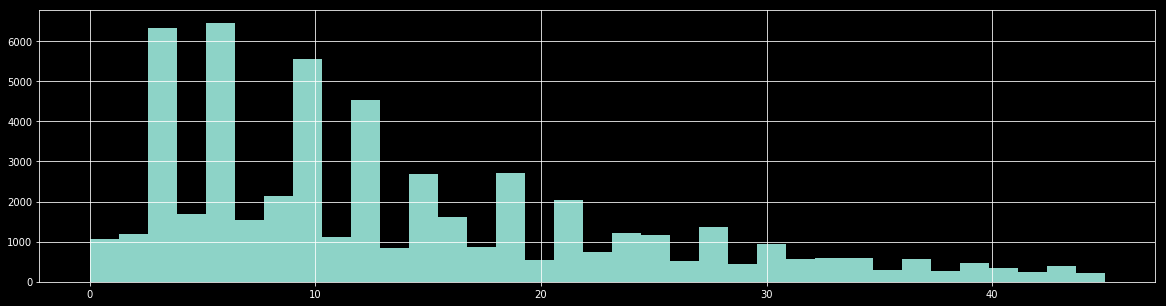

In [203]:
ax_time = dest_df.travel_time_minutes[dest_df.travel_time_minutes < 45].hist(bins=35, figsize=(20, 5))

In [204]:
ax_time.get_figure().savefig('./drive_time.png')

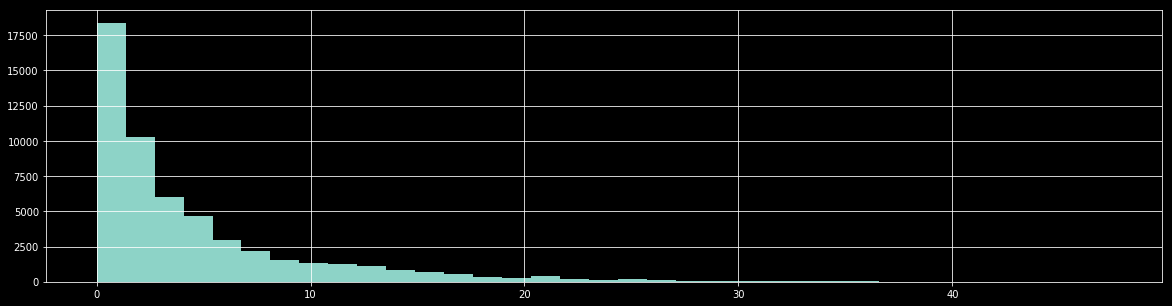

In [205]:
ax_dist = dest_df.travel_distance_miles[dest_df.travel_time_minutes < 45].hist(bins=35, figsize=(20, 5))

In [206]:
ax_time.get_figure().savefig('./drive_dist.png')

In [222]:
print(f'mean distance -   {dest_df.travel_distance_miles.mean()}')
print(f'mean time -       {dest_df.travel_time_minutes.mean()}')
print(f'median distance - {dest_df.travel_distance_miles.median()}')
print(f'median time -     {dest_df.travel_time_minutes.median()}')
print(f'std distance -    {dest_df.travel_distance_miles.std()}')
print(f'std time -        {dest_df.travel_time_minutes.std()}')

mean distance -   6.264441982749813
mean time -       17.191594081469976
median distance - 2.711041673
median time -     12.116666666666667
std distance -    11.608082121750348
std time -        17.909360176252484


In [214]:
import math

cust_80_count = math.floor(len(dest_df.index) * .8)
print(f'{cust_80_count:,}')

45,831


In [220]:
dest_df.sort_values('travel_distance_miles', ascending=True).iloc[cust_80_count]['travel_distance_miles']

9.062074664

In [109]:
sing_dest_df = sing_dest_df[['store_locnum', 'ID', 'SHAPE']].copy()
sing_dest_df.columns = ['destination_id', 'origin_id', 'SHAPE']
sing_dest_df.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [110]:
sing_dest_df.spatial.to_featureclass(str(interim_gdb/'trips_raw_409083547'))

'D:\\projects\\geoai-retail\\data\\interim\\interim.gdb\\trips_raw_409083547'

In [112]:
self = ba_data

In [116]:
fc_businesses = os.path.join(self.usa_data_path, r'Data\Business Data\BA_BUS_2018.gdb\us_businesses')
lyr_businesses = arcpy.management.MakeFeatureLayer(fc_businesses)[0]
lyr_businesses

In [118]:
naics_codes = 0
sic_codes = 'yes'

In [124]:
codes = naics_codes

In [133]:
biz_lyr = arcpy.management.MakeFeatureLayer(dest_fc)

naics_code_lst = set(r[0] for r in arcpy.da.SearchCursor(biz_lyr, 'NAICS'))
naics_sql = ' OR '.join(f"NAICS = '{naics}'" for naics in naics_code_lst)

existing_locnum_lst = [r[0] for r in arcpy.da.SearchCursor(biz_lyr, 'LOCNUM')]
existing_sql = ' AND '.join([f"LOCNUM <> '{locnum}'" for locnum in existing_locnum_lst])

sql = f"{naics_sql} AND ({existing_sql})"

comp_lyr = ba_data.layer_businesses
comp_lyr.definitionQuery = sql

In [157]:
print(f'{int(arcpy.management.GetCount(comp_lyr)[0]):,}')

17,276


In [159]:
comp_lyr = ba_data.get_business_competitor_layer(biz_lyr)
print(f'{int(arcpy.management.GetCount(comp_lyr)[0]):,}')

17,276
